### Importing Packages

In [2]:
import os
import json
import pandas as pd
from typing import Literal, List, Optional, cast
from typing_extensions import TypedDict

# Message Types
from langchain_core.messages import AIMessage, ToolMessage, SystemMessage

# Graph
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

# Tools
from langchain.tools import tool

# Memory
from langchain_core.runnables import RunnableConfig

# !pip install googlemaps
import googlemaps


import pprint
pp = pprint.PrettyPrinter(indent=1)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# !pip install mapboxgl --quiet

from mapboxgl.utils import create_color_stops, df_to_geojson
from mapboxgl.viz import CircleViz

### OpenAI Inference

In [4]:
# Load OPENAI Key using dotenv
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get the OpenAI API key from environment variables
openai_api_key = os.getenv("OPENAI_API_KEY")
if openai_api_key is None:
    raise ValueError("OpenAI API key not found. Please set it in the .env file.")

In [5]:
# For search node
gmaps = googlemaps.Client(key=os.getenv("GOOGLE_MAPS_API_KEY"))
gmaps

In [6]:
# Creating the LLM Object
from langchain_openai import ChatOpenAI
llm=ChatOpenAI()
llm

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7fb01939d5a0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7fb01939f6a0>, root_client=<openai.OpenAI object at 0x7fb008722740>, root_async_client=<openai.AsyncOpenAI object at 0x7fb01939d600>, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [7]:
map_box_token = os.getenv('MAPBOX_ACCESS_TOKEN')
print(map_box_token)

pk.eyJ1Ijoia21pdHRhbCIsImEiOiJjbWJ2NXUxMDcwOXFkMm5weTBlYWh3cTNrIn0.KjTxbhQznJtdCDd1JKBuyg


### Define Langraph States

In [8]:
# State Definition

class Place(TypedDict): # Place Details
    """A place."""
    id: str
    name: str
    address: str
    latitude: float
    longitude: float
    rating: float
    description: Optional[str]

class Trip(TypedDict): # Trip Details
    """A trip."""
    id: str
    name: str
    center_latitude: float
    center_longitude: float
    zoom: int # 13 for city, 15 for airport
    places: List[Place]

class SearchProgress(TypedDict): # Search Progress Details
    """The progress of a search."""
    query: str
    results: list[str]
    done: bool

class PlanningProgress(TypedDict): # Planning Progress Details
    """The progress of a planning."""
    trip: Trip
    done: bool

class AgentState(MessagesState):   # To store the messages flowing through the AI Process
    """The state of the agent."""
    selected_trip_id: Optional[str]             # The selected trip ID
    trips: List[Trip]                           # Contains the places
    search_progress: List[SearchProgress]
    planning_progress: List[PlanningProgress]

Define Memory Thread

In [9]:
# 2. Thread for Memory
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

### Architecture

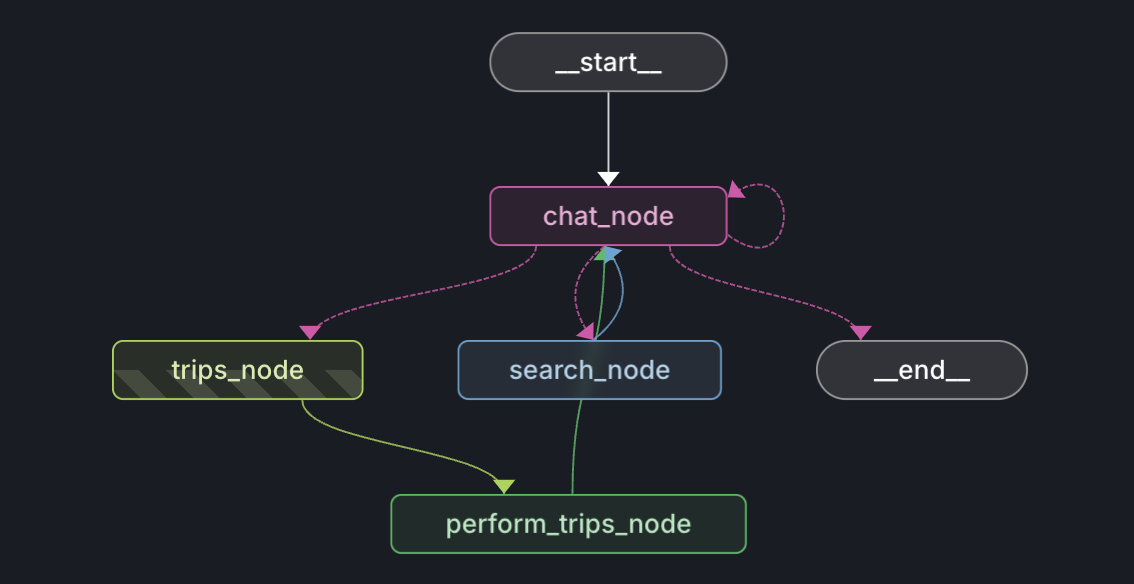

____
### **Tools**

In [10]:
@tool
def search_for_places(queries: list[str]) -> list[dict]:
    """Search for places based on a query, returns a list of 
    places including their name, address, and coordinates."""


In [11]:
@tool
def add_trips(trips: List[Trip]):
    """Add one or many trips to the list"""

def handle_add_trips(state: AgentState, args: dict,
                     tool_call_id=None) -> ToolMessage:
    # Get the trip to be added 
    trips = args.get("trips", [])

    # Extend trips in state
    state["trips"].extend(trips)
    return ToolMessage(
        tool_call_id=tool_call_id,
        content=f"Successfully added the trip(s)!"
        )

In [12]:
@tool
def delete_trips(trip_ids: List[str]):
    """Delete one or many trips. YOU MUST NOT CALL this tool multiple times in a row!"""

def handle_delete_trips(state: AgentState, args: dict,
                        tool_call_id=None) -> ToolMessage:
    trip_ids = args.get("trip_ids", [])
    
    # Clear selected_trip if it's being deleted
    if state.get("selected_trip_id") and state["selected_trip_id"] in trip_ids:
        state["selected_trip_id"] = None

    state["trips"] = [trip for trip in state["trips"] if trip["id"] not in trip_ids]
    return ToolMessage(
        tool_call_id=tool_call_id,
        content=f"Successfully deleted the trip(s)!"
        )

@tool
def update_trips(trips: List[Trip]):
    """Update one or many trips"""

def handle_update_trips(state: AgentState, args: dict,
                        tool_call_id=None) -> ToolMessage:
    trips = args.get("trips", [])
    for trip in trips:
        state["trips"] = [
            {**existing_trip, **trip} if existing_trip["id"] == trip["id"] else existing_trip
            for existing_trip in state["trips"]
        ]
    return ToolMessage(
        tool_call_id=tool_call_id,
        content=f"Successfully updated the trip(s)!"
        )

In [13]:
@tool
def select_trip(trip_id: str):
    """Select a trip"""
    return f"Selected trip {trip_id}"

In [14]:
@tool
def map_trip(trip_id: str):
    """Map a trip by its ID."""
    return f"Mapping trip {trip_id}"

In [15]:
tools = [search_for_places, 
         add_trips, delete_trips, update_trips,
         select_trip,
         map_trip]

____
### **Nodes**

#### Chat Node - Supervisor Node

In [ ]:
def chat_node(state: AgentState,    # Graph State 
              config: RunnableConfig):        # Graph Memory
    """Handle chat operations"""
    llm_with_tools = llm
    llm_with_tools = llm.bind_tools(
        [
            *tools,
        ],
        parallel_tool_calls=False,
    )

    system_message = f"""
    You are an agent that plans trips and helps the user with planning and managing their trips.
    If the user did not specify a location, you should ask them for a location.
    
    Plan the trips for the user, take their preferences into account if specified, but if they did not
    specify any preferences, call the search_for_places tool to find places of interest, restaurants, and activities.
    
    Unless the users prompt specifies otherwise, only use the first 3 results from the search_for_places tool relevant
    to the trip.
    
    When you add or edit a trip, you don't need to summarize what you added. Just give a high level summary of the trip
    and why you planned it that way.
    
    If the user asks to add it to the same trip, then you should update the trip rather than add a new one.
    
    When you create or update a trip, you should very importantly set it as the selected trip.
    If you delete a trip, try to select another trip.

    Ask the user if they want to finalize the trip after you have planned it. If they ask to select/finalize the trip, then run the select_trip tool with the trip ID.
    
    Once the user has finalized the trip, ask if they want to make a map for it.
    
    If an operation is cancelled by the user, DO NOT try to perform the operation again. Just ask what the user would like to do now
    instead.

    Current trips: {json.dumps(state.get('trips', []))}
    """

    # calling ainvoke instead of invoke is essential to get streaming to work properly on tool calls.
    
    # Getting the llm output
    response = llm_with_tools.invoke(
        input=[
            SystemMessage(content=system_message),  # Convert the prompt to the system message
            *state["messages"]                      # Feed conversations executed till now
        ],
        config=config,
    )

    # Casting Chat Node Output to AIMessage
    ai_message = cast(AIMessage, response)

    # Check if the AI message contains tool calls
    if ai_message.tool_calls:
        # Check if the first tool call is "select_trip"
        if ai_message.tool_calls[0]["name"] == "select_trip":
            # Extract the trip ID from the tool call arguments
            return {
                "selected_trip_id": ai_message.tool_calls[0]["args"].get("trip_id", ""),
                
                # Update the messages dict in state 
                "messages": [ai_message, # AI Message Output - Tool Call
                             ToolMessage(tool_call_id=ai_message.tool_calls[0]["id"], # Tool Message associated with a tool call id
                                                     content="Trip selected."
                )]
            }

    # Final Output of the chat node
    return {
        "messages": [response],
        "selected_trip_id": state.get("selected_trip_id", None),
        "trips": state.get("trips", [])
    }

#### Search Node

In [ ]:
def search_node(state: AgentState, config: RunnableConfig):
    """
    The search node is responsible for searching for the places.
    """
    # Convert the last message in the state to an AI Message 
    ai_message = cast(AIMessage, state["messages"][-1])

    # Get the search progress from active graph state
    state["search_progress"] = state.get("search_progress", [])
    
    # Get the queries from the Tool Call in the AI Message
    queries = ai_message.tool_calls[0]["args"]["queries"]

    # Update search progress in state
    for query in queries:
        state["search_progress"].append({
            "query": query,
            "results": [],
            "done": False
        })

    # Initiate the places list
    places = []
    
    # The LLM will create the user request to queries 
    # These queries are sent independently to the Google Maps API
    for i, query in enumerate(queries):
        
        # Get the response dictionary from the Google Maps API
        response = gmaps.places(query)
        # Parse the response dictionary
        for result in response.get("results", []):
            # Extract place information from gmaps response
            place = {
                "id": result.get("place_id", f"{result.get('name', '')}-{i}"),
                "name": result.get("name", ""),
                "address": result.get("formatted_address", ""),
                "latitude": result.get("geometry", {}).get("location", {}).get("lat", 0),
                "longitude": result.get("geometry", {}).get("location", {}).get("lng", 0),
                "rating": result.get("rating", 0),
            }
            places.append(place)
        # Update the search progress in state
        state["search_progress"][i]["done"] = True

    # Re-initiating the search progress
    state["search_progress"] = []

    # Adding tool message to the state
    state["messages"].append(ToolMessage(
        tool_call_id=ai_message.tool_calls[0]["id"],
        content=f"Added the following search results: {json.dumps(places)}"
    ))

    return state

Working of The Google Maps API

In [22]:
response = gmaps.places("places of interest in Chicago")
for result in response.get("results", []):
    place = {
        "id": result.get("place_id", f"{result.get('name', '')}"),
        "name": result.get("name", ""),
        "address": result.get("formatted_address", ""),
        "latitude": result.get("geometry", {}).get("location", {}).get("lat", 0),
        "longitude": result.get("geometry", {}).get("location", {}).get("lng", 0),
        "rating": result.get("rating", 0),
    }
    print(place)

{'id': 'ChIJu_tp4r4sDogR_dRFCX8wCc8', 'name': 'Skydeck Chicago', 'address': '233 S Wacker Dr, Chicago, IL 60606, United States', 'latitude': 41.87887610000001, 'longitude': -87.635915, 'rating': 4.6}
{'id': 'ChIJ2y7xkU0rDogR3KSIsJbbrNA', 'name': 'Navy Pier', 'address': '600 E Grand Ave, Chicago, IL 60611, United States', 'latitude': 41.8918633, 'longitude': -87.6050944, 'rating': 4.6}
{'id': 'ChIJNbKQElTTD4gRdOsDd3qTFHM', 'name': '360 CHICAGO', 'address': '875 N Michigan Ave 94th floor, Chicago, IL 60611, United States', 'latitude': 41.8990104, 'longitude': -87.6232416, 'rating': 4.5}
{'id': 'ChIJn2gRpa4sDogR1WNoXyHTkn0', 'name': 'The Wrigley Building', 'address': '400-410 Michigan Ave, Chicago, IL 60611, United States', 'latitude': 41.88970399999999, 'longitude': -87.6245898, 'rating': 4.7}
{'id': 'ChIJA5xPiqYsDogRBBCptdwsGEQ', 'name': 'Millennium Park', 'address': 'Chicago, IL 60602, United States', 'latitude': 41.8825524, 'longitude': -87.62255139999999, 'rating': 4.7}
{'id': 'ChIJX

#### Trips Node

In [ ]:
def perform_trips_node(state: AgentState, config: RunnableConfig):
    """Execute trip operations"""
    
    # Extract the AI message from the state
    ai_message = cast(AIMessage, state["messages"][-1])
    
    # Initialize the trips list if it doesn't exist
    if not state.get("trips"):
        state["trips"] = []
        
    for tool_call in ai_message.tool_calls:
        action = tool_call["name"]
        args = tool_call.get("args", {})
        # Extract the tool call ID from the AI message
        tool_call_id = tool_call["id"]

        if action == "add_trips":
            message = handle_add_trips(state, args, tool_call_id)
            state["messages"].append(message)
        elif action == "delete_trips":
            message = handle_delete_trips(state, args, tool_call_id)
            state["messages"].append(message)
        elif action == "update_trips":
            message = handle_update_trips(state, args, tool_call_id)
            state["messages"].append(message)
        # Optionally handle unknown actions

    return state


#### Map Node

In [47]:
def trip_to_geojson(trip):
    features = []
    for place in trip.get("places", []):
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [place["longitude"], place["latitude"]],
            },
            "properties": {
                "id": place.get("id"),
                "name": place.get("name"),
                "address": place.get("address"),
                "rating": place.get("rating"),
                "description": place.get("description"),
            }
        }
        features.append(feature)
    geojson = {
        "type": "FeatureCollection",
        "features": features
    }
    return geojson

def map_trip_node(state: AgentState, config: RunnableConfig):
    """ Map the selected trip ID """
    
    # Get the AI message from chat node
    ai_message = cast(AIMessage, state["messages"][-1])
    
    # Get the selected trip ID from the state
    selected_trip_id = state.get("selected_trip_id")
    
    # If no trip is selected, return an error message
    if not selected_trip_id:
        return {
            "messages": [AIMessage(content="No trip selected to map.")],
            "selected_trip_id": None
        }

    # Find the trip in the state
    selected_trip = next((trip for trip in state["trips"] if trip["id"] == selected_trip_id), None)
    
    # If no trip is found, return an error message
    if not selected_trip:
        return {
            "messages": [AIMessage(content="Selected trip not found.")],
            "selected_trip_id": None
        }

    # Convert the trip to GeoJSON format
    trip_geojson = trip_to_geojson(selected_trip)
    
    # Mapbox Configurations
    center = selected_trip.get("center_longitude"), selected_trip.get("center_latitude")
    zoom = selected_trip.get("zoom")
    style_url = 'mapbox://styles/mapbox/outdoors-v11'
    color_breaks = range(0, 6)
    color_stops = create_color_stops(color_breaks, colors='YlGnBu')

    # Create a Mapbox CircleViz object
    viz = CircleViz(style=style_url,
                    data=trip_geojson,
                    access_token=map_box_token,
                    height='400px',
                    width='1000px',
                    color_property = "rating",
                    color_stops = color_stops,
                    center = center,
                    zoom = zoom-1,
                    stroke_width = 1,
                    stroke_color = 'black',
                    radius=3,
                    below_layer = 'poi-label',
                )

    viz.show()
    
    # Save the map as an HTML file
    viz.create_html("trip_map.html")
    
    state["messages"].append(ToolMessage(
        tool_call_id=ai_message.tool_calls[0]["id"],
        content=f"Mapped the trip {selected_trip_id} successfully. You can view it at: {os.path.abspath('trip_map.html')}"
    ))
    
    return state

_______
### **Making the Graph**

#### Router

In [48]:
def chat_router(state: AgentState):
    """Route after the chat node."""
    # Extract the messages from the state
    messages = state.get("messages", [])
    # If the message is present and last instance of message is also AI Message
    if messages and isinstance(messages[-1], AIMessage):
        
        # Get the latest message as AI Message
        ai_message = cast(AIMessage, messages[-1])
        
        # If the last AI message has tool calls we need to determine to route to the
        # trips_node or search_node based on the tool name.
        if ai_message.tool_calls:
            tool_name = ai_message.tool_calls[0]["name"]
            if tool_name in ["add_trips", "update_trips", "delete_trips", "select_trip"]:
                return "perform_trips_node"
            if tool_name in ["search_for_places"]:
                return "search_node"
            if tool_name in ["map_trip"]:
                return "map_trip_node"
            return "chat_node"
    
    # If the message is present and last instance of message is also Tool Message
    # We return to chat node
    if messages and isinstance(messages[-1], ToolMessage):
        return "chat_node"
    
    # If there is no message, we end the graph run
    return END

#### Final Graph

In [49]:
# Initiate a state graph
graphbuilder=StateGraph(AgentState)

# Add Nodes
graphbuilder.add_node("chat_node", chat_node)
graphbuilder.add_node("search_node", search_node)

# Trips
graphbuilder.add_node("perform_trips_node", perform_trips_node)

# Map Node
graphbuilder.add_node("map_trip_node", map_trip_node)

# Add Edges
graphbuilder.add_edge(START, "chat_node")
graphbuilder.add_conditional_edges("chat_node", chat_router, ["search_node",
                                                              "chat_node", 
                                                              "perform_trips_node",
                                                              "map_trip_node",
                                                              END])

graphbuilder.add_edge("search_node", "chat_node")
graphbuilder.add_edge("perform_trips_node", "chat_node")
graphbuilder.add_edge("map_trip_node", "chat_node")

# Compile the graph
graph = graphbuilder.compile(
        checkpointer=MemorySaver(),
        # interrupt_after=["perform_trips_node"]
    )

graph

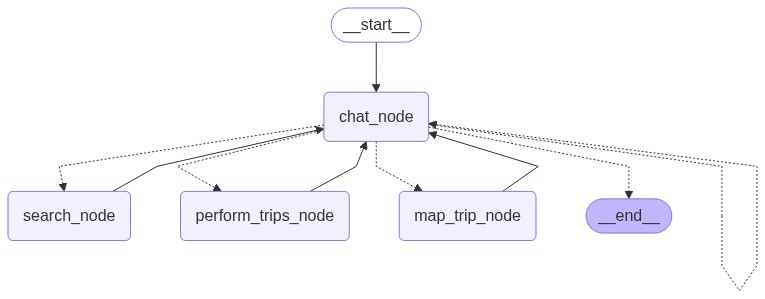

In [50]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

-----
### User Demo

In [62]:
user_input="Can you plot it on the map for me?"

# Run
state_run = graph.invoke({"messages": user_input},
                        config)
for m in state_run['messages'][-2:]:
    m.pretty_print()

/Users/kshitijmittal/opt/anaconda3/envs/GENAI_v01/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


================================= Tool Message =================================

Mapped the trip trip1 successfully. You can view it at: /Users/kshitijmittal/Documents/05_GenAI/03_LangGraph/practice-travel/trip_map.html
================================== Ai Message ==================================

The trip has been successfully plotted on the map. You can view the map [here](sandbox:/Users/kshitijmittal/Documents/05_GenAI/03_LangGraph/practice-travel/trip_map.html). If you need any more assistance or have any other requests, feel free to let me know!


In [64]:
state_run

{'messages': [HumanMessage(content='Hey, I am planning a trip to Gurgaon', additional_kwargs={}, response_metadata={}, id='cd52ddac-6902-493f-910f-55337234fe17'),
  AIMessage(content='Great choice! Would you like me to search for places of interest, restaurants, and activities in Gurgaon for your trip?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 653, 'total_tokens': 680, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-4d04ef9a-0bac-4e89-87d2-3e85c030e43a-0', usage_metadata={'input_tokens': 653, 'output_tokens': 27, 'total_tokens': 680}),
  HumanMessage(content='Find best north indian restaurants for my trip.', additional_kwargs={}, response_metad

In [30]:
user_input="Can you plot it on the map for me?"

# Run
state_run = graph.invoke({"messages": user_input},
                        config)
for m in state_run['messages']:
    m.pretty_print()

/Users/kshitijmittal/opt/anaconda3/envs/GENAI_v01/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


================================ Human Message =================================

Hey, I am Kshitij!
================================== Ai Message ==================================

Hello Kshitij! How can I assist you today?
================================ Human Message =================================

I am planning a trip to Chicago. Can you help me?!
================================== Ai Message ==================================

Of course, I'd be happy to help you plan your trip to Chicago! Do you have any specific preferences or places you'd like to visit in Chicago, or would you like me to suggest some popular attractions, restaurants, and activities in the city?
================================ Human Message =================================

Find best food places for me
================================== Ai Message ==================================
Tool Calls:
  search_for_places (call_BlA6PrU57s9AoMfHugksKDgM)
 Call ID: call_BlA6PrU57s9AoMfHugksKDgM
  Args:
    queries: [

In [28]:
for m in state_run['trips']:
    pp.pprint(m)

{'center_latitude': 41.8781,
 'center_longitude': -87.6298,
 'id': '1',
 'name': 'Chicago Food Trip',
 'places': [{'address': '444 Michigan Ave, Chicago, IL 60611, United States',
             'id': 'ChIJl8NTEawsDogRwXH-IVDyH2A',
             'latitude': 41.890739,
             'longitude': -87.6245691,
             'name': 'The Purple Pig Restaurant',
             'rating': 4.6},
            {'address': '564 W Randolph St, Chicago, IL 60661, United States',
             'id': 'ChIJEUAV9zMtDogRJbm6cdw59JE',
             'latitude': 41.884577,
             'longitude': -87.64252139999999,
             'name': 'Alla Vita',
             'rating': 4.8},
            {'address': '809 W Randolph St, Chicago, IL 60607, United States',
             'id': 'ChIJs8mbNsUsDogRUnpg-b_IK5E',
             'latitude': 41.8841831,
             'longitude': -87.64794529999999,
             'name': 'Girl & The Goat',
             'rating': 4.7}],
 'zoom': 12}
